In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
%matplotlib inline
from typing import Callable, Sequence
import functools as ft
import optax
from sdf_jax.discretize import discretize2d
from sdf_jax.util import plot2d

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


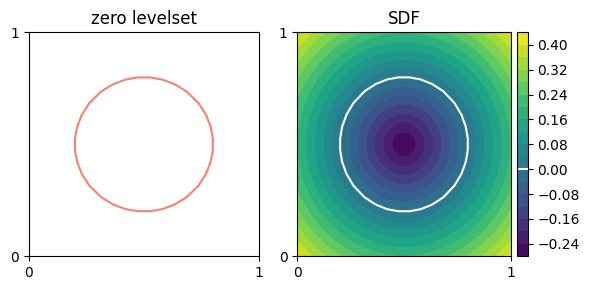

In [2]:
def sdf_sphere(x, radius=0.3, center=jnp.array([0.5, 0.5])):
    return jnp.linalg.norm(x - center) - radius

plot2d(sdf_sphere, ngrid=20)

In [3]:
def get_datasets(ntrain=100, ngrid=50, sdf=sdf_sphere):
    xs, ys = discretize2d(sdf, ngrid=ngrid, x_lims=(0,1), y_lims=(0,1))
    xs = xs.reshape(-1, 2)
    ys = ys.reshape(-1, 1)
    permutation = jrandom.permutation(jrandom.PRNGKey(0), len(xs))
    xs = xs[permutation]
    ys = ys[permutation]
    train_xs, train_ys = xs[:ntrain], ys[:ntrain]
    test_xs, test_ys = xs[ntrain:], ys[ntrain:]
    return train_xs, train_ys, test_xs, test_ys

In [4]:
import flax
from flax import linen as nn

class SimpleNeuralSDF(nn.Module):
    """A simple neural SDF model."""
    features: Sequence[int]
    activation: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        for i, feature in enumerate(self.features):
            x = nn.Dense(feature, name=f"dense_{i}")(x)
            x = self.activation(x)
        x = nn.Dense(1, name=f"dense_out")(x)
        return x

In [5]:
module = SimpleNeuralSDF([32, 32])
print(module.tabulate(jrandom.PRNGKey(0), jnp.ones((1, 2))))


                            SimpleNeuralSDF Summary                             
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path      ┃ module          ┃ inputs        ┃ outputs       ┃ params         ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│           │ SimpleNeuralSDF │ float32[1,2]  │ float32[1,1]  │                │
├───────────┼─────────────────┼───────────────┼───────────────┼────────────────┤
│ dense_0   │ Dense           │ float32[1,2]  │ float32[1,32] │ bias:          │
│           │                 │               │               │ float32[32]    │
│           │                 │               │               │ kernel:        │
│           │                 │               │               │ float32[2,32]  │
│           │                 │               │               │                │
│           │                 │               │               │ 96 (384 B)     │
├───────────┼──────────────

In [6]:
from clu import metrics
from flax.training import train_state

@flax.struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(rng, module, learning_rate):
    params = module.init(rng, jnp.ones((1, 2)))['params']
    tx = optax.adam(learning_rate)
    return TrainState.create(
        apply_fn=module.apply, params=params, tx=tx, metrics=Metrics.empty())

In [7]:
@jax.jit
def compute_metrics(state, batch):
    preds = state.apply_fn({'params': state.params}, batch['x'])
    loss = jnp.mean((preds - batch['y']) ** 2)
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        preds = state.apply_fn({'params': params}, batch['x'])
        return jnp.mean((preds - batch['y']) ** 2)
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

In [8]:
train_xs, train_ys, test_xs, test_ys = get_datasets(ntrain=100, ngrid=50)
print(train_xs.shape, train_ys.shape, test_xs.shape, test_ys.shape)

(100, 2) (100, 1) (2400, 2) (2400, 1)


In [9]:
def dataloader(xs, ys, batch_size, *, rng):
    dataset_size = xs.shape[0]
    assert batch_size <= dataset_size
    assert dataset_size == ys.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(rng, indices)
        (rng,) = jrandom.split(rng, 1)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield {'x': xs[batch_perm], 'y': ys[batch_perm]}
            start = end
            end = start + batch_size

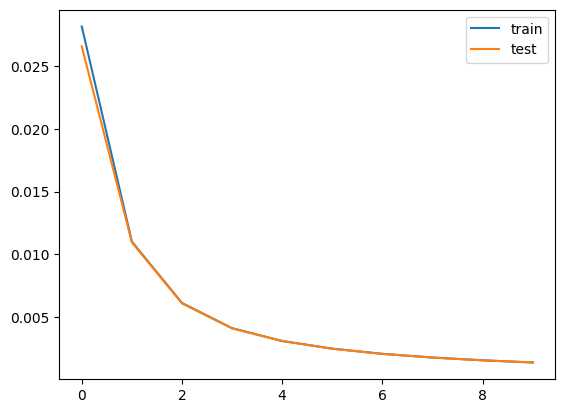

In [10]:
metrics_history = {
    'train': [],
    'test': [],
}

init_rng = jrandom.PRNGKey(1234)
learning_rate = 5e-3
state = create_train_state(init_rng, module, learning_rate)
del init_rng # Must not be used anymore.

data_rng = jrandom.PRNGKey(0)
data_loader = dataloader(train_xs, train_ys, batch_size=32, rng=data_rng)

for step, batch in zip(tqdm(range(1000)), data_loader):
    state = train_step(state, batch)
    state = compute_metrics(state, batch)
    if step % 100 == 0:
        train_metrics = state.metrics.compute()
        test_metrics = compute_metrics(state, {'x': test_xs, 'y': test_ys}).metrics.compute()
        metrics_history['train'].append(train_metrics['loss'])
        metrics_history['test'].append(test_metrics['loss'])
        clear_output(wait=True)
        plt.plot(metrics_history['train'], label='train')
        plt.plot(metrics_history['test'], label='test')
        plt.legend()
        plt.show()

In [11]:
@jax.jit
def predict(x):
    assert x.ndim == 1
    return state.apply_fn({'params': state.params}, x).reshape()

predict(jnp.array([0.5, 0.5]))

Array(-0.24296483, dtype=float32)

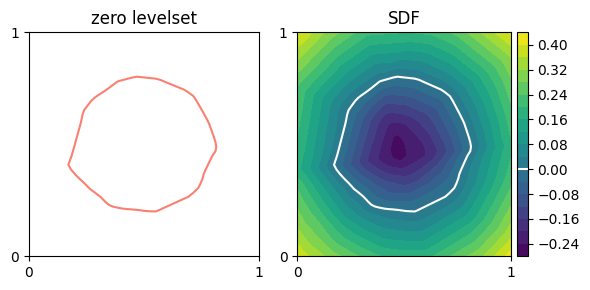

In [12]:
plot2d(predict, ngrid=50)